In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import zscore
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("Fraud.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [3]:
# TO remove columns which has one single value.
for i in df:
    if df[f"{i}"].nunique()==1:
        print(i,"has single unique value")
    else :
        continue

So all the columns have multiple values.

In [4]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

### Checking for missing values

In [5]:
def missing_val(df):
    Missing_values=df.isna().sum()
    Percent_missing_values=100*df.isna().sum()/len(df)
    tab=pd.concat([Missing_values,Percent_missing_values.round(2)],axis=1)
    tab.columns=['Missing_values','Percent_missing_values']
    tab=tab[tab['Percent_missing_values']>0].sort_values('Percent_missing_values',ascending=False)
    return(tab.style.background_gradient('Reds'))

missing_val(df)

,Missing_values,Percent_missing_values


In [6]:
df.duplicated().sum()

0

In [7]:
df.isin(['NAN','NA','N/A','-',' ','?',np.nan]).sum().any()

False

#### No missing values are present in the dataset

# Exploratory Data Analysis


0    6354407
1       8213
Name: isFraud, dtype: int64


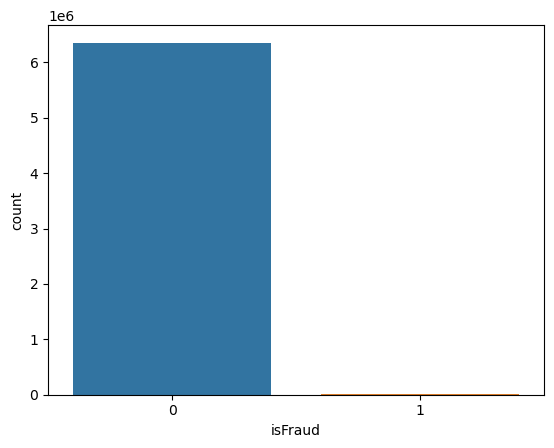

In [8]:
sns.countplot(df["isFraud"])
print(df["isFraud"].value_counts())

#### This shows that in the dataset, non fraudulent transactions are much more than the fraudulent transactions.

[Text(0, 0.5, 'Number of Transactions'),
 Text(0.5, 0, 'Type'),
 Text(0.5, 1.0, 'Type of transaction')]

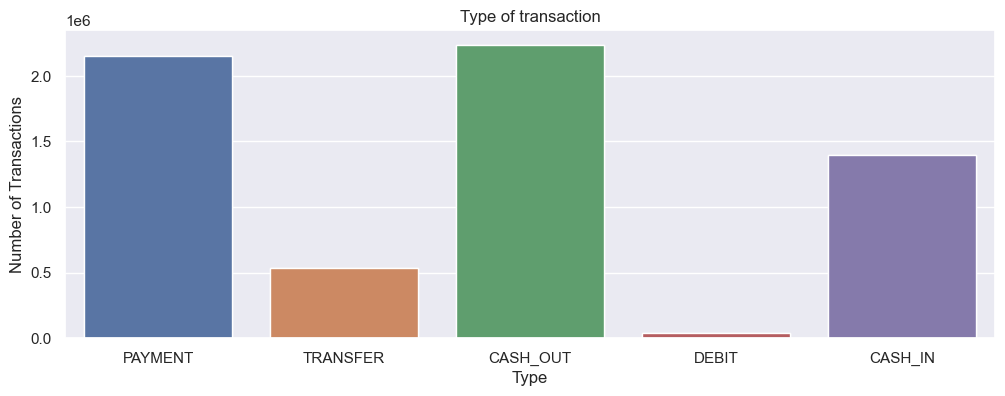

In [9]:
sns.set(rc={"figure.figsize":(12, 4)})
ax=sns.countplot(df["type"])
sns.countplot(df["type"])
ax.set(ylabel='Number of Transactions', xlabel='Type', title="Type of transaction")

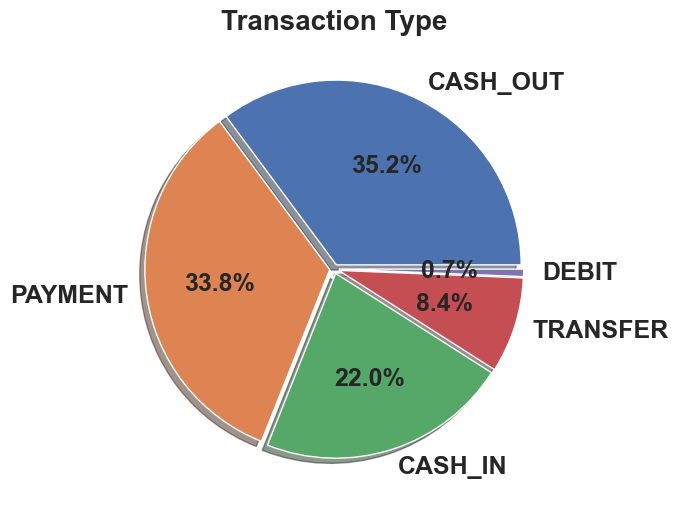

In [10]:
f,ax=plt.subplots(1,1,figsize=(10,6))
df["type"].value_counts().plot.pie(explode=[0.025,0.025,0.025,0.025,0.025],autopct='%3.1f%%',
                                          textprops ={ 'fontweight': 'bold','fontsize':18}, ax=ax,shadow=True)
ax.set_title('Transaction Type', fontsize=20,fontweight ='bold')
ax.set_ylabel('')

plt.xticks(fontsize=18,fontweight ='bold')
plt.show()

#### The most common type of transactions are Cash-outs, Payment and Cash-ins

<AxesSubplot:xlabel='amount', ylabel='step'>

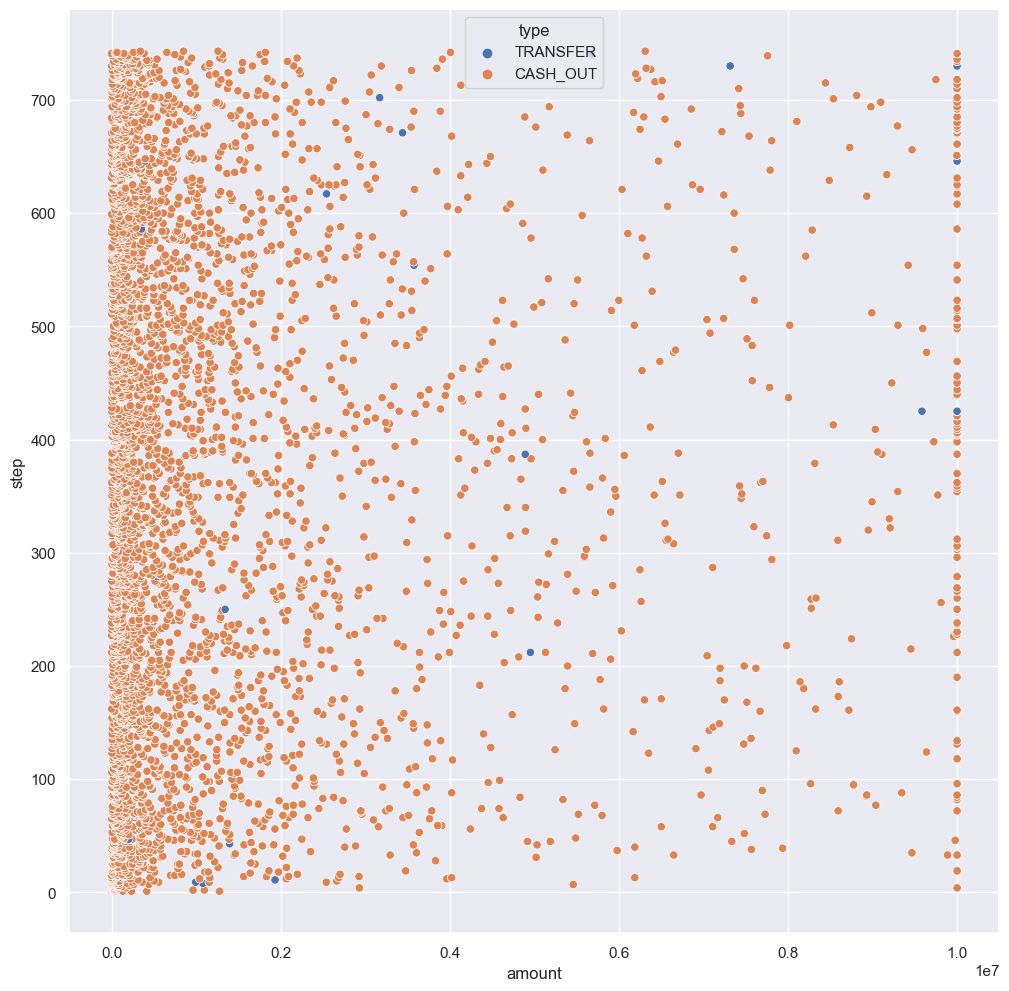

In [11]:
sns.set(rc={"figure.figsize":(12, 12)})
sns.scatterplot(data=df[df["isFraud"]==1], x="amount", y="step", hue="type",)

### We can conclude following points here:
    
    - Most transactions are of smaller amounts

<AxesSubplot:xlabel='isFraud', ylabel='count'>

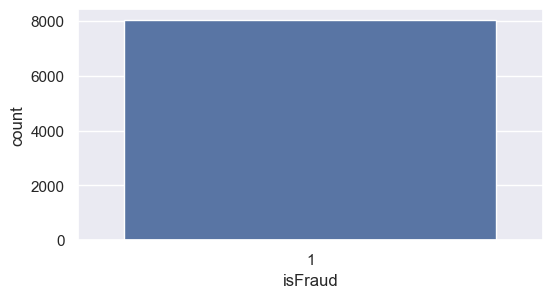

In [12]:
sns.set(rc={"figure.figsize":(6, 3)})
sns.countplot(df[df["amount"]==df["oldbalanceOrg"]]["isFraud"])

### This shows that all those transactions where the transaction amount is equal to balance of the customer who started the transaction(entire account balance is transacted in a single transaction), the transaction is fraudulent.

## Variable Selection and Transformations

  nameOrig - name of customer who started the transaction.
  
  nameDest - name of customer who is the recipient of the transaction

These two columns consists of the names of people involved in the transaction, which has no contributution in deciding if the transaction is a fraud.

So, we will remove these two columns.

In [13]:
df1=df.drop(["nameOrig","nameDest"],axis=1)

In [14]:
df1

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0


### Encoding of categorical data

In [15]:
# Changing categorical data to numerical
ohe=OneHotEncoder()
x=df1[["type"]].values
x=ohe.fit_transform(x).toarray()
y=z=np.hstack(ohe.categories_)
merge= pd.DataFrame(data=x,columns=y)
dfn=pd.concat([df1,merge],axis=1)
pd.set_option('display.max_columns',None)
dfn

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,0.0,1.0,0.0,0.0,0.0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,0.0,1.0,0.0,0.0,0.0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0.0,1.0,0.0,0.0,0.0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0


#### To remove multicolinearity between the encoded columns, we will remove one of the new columns and column- "type"

In [16]:
dfn.drop(["type","DEBIT"],axis=1, inplace=True)

In [17]:
dfn

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,PAYMENT,TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0.0,0.0,1.0,0.0
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0.0,0.0,0.0,1.0
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,0.0,1.0,0.0,0.0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,0.0,1.0,0.0,0.0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0.0,0.0,0.0,1.0
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0.0,1.0,0.0,0.0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,0.0,0.0,0.0,1.0


### Outlier Treatment

In [18]:
z=np.abs(zscore(dfn,axis=1))
dff=dfn[(z<3).all(axis=1)]
dff

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,PAYMENT,TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0.0,0.0,1.0,0.0
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0.0,0.0,0.0,1.0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0.0,0.0,1.0,0.0
5,1,7817.71,53860.00,46042.29,0.00,0.00,0,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,0.0,1.0,0.0,0.0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0.0,0.0,0.0,1.0
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0.0,1.0,0.0,0.0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,0.0,0.0,0.0,1.0


Number of rows in original dataframe- 6362620 
Number of rows after outlier treatment - 5356725

6362620-5356725=1005895, which is 15.8% of the total data entries. So, outlier reduction is within limits.

### Treating Skewness

In [19]:
#Checking skewness
dff.skew()

step                0.388003
amount             30.127675
oldbalanceOrg       4.784625
newbalanceOrig      4.718044
oldbalanceDest     18.686607
newbalanceDest     18.458422
isFraud            25.526813
isFlaggedFraud    578.612565
CASH_IN             1.090171
CASH_OUT            0.359404
PAYMENT             1.340027
TRANSFER            2.695889
dtype: float64

In [20]:
dff["isFlaggedFraud"].unique()

array([0, 1], dtype=int64)

In [21]:
dff["isFraud"].unique()

array([0, 1], dtype=int64)

As column "isFlaggedFraud", "isFraud", "CASH_IN", "CASH_OUT","PAYMENT", and "TRANSFER" contains only 0 and 1 values, we do not need to treat for the skewness.

In [22]:
from sklearn.preprocessing import power_transform

dff[['amount','oldbalanceDest','newbalanceDest','oldbalanceOrg','newbalanceOrig']]=power_transform(dff[['amount','oldbalanceDest','newbalanceDest','oldbalanceOrg','newbalanceOrig']],method='yeo-johnson')

In [23]:
dff.skew()

step                0.388003
amount              0.005235
oldbalanceOrg      -0.132618
newbalanceOrig      0.093443
oldbalanceDest     -0.389149
newbalanceDest     -0.458627
isFraud            25.526813
isFlaggedFraud    578.612565
CASH_IN             1.090171
CASH_OUT            0.359404
PAYMENT             1.340027
TRANSFER            2.695889
dtype: float64

Skwness has been treated successfully

### To check for multicoliearity

<AxesSubplot:>

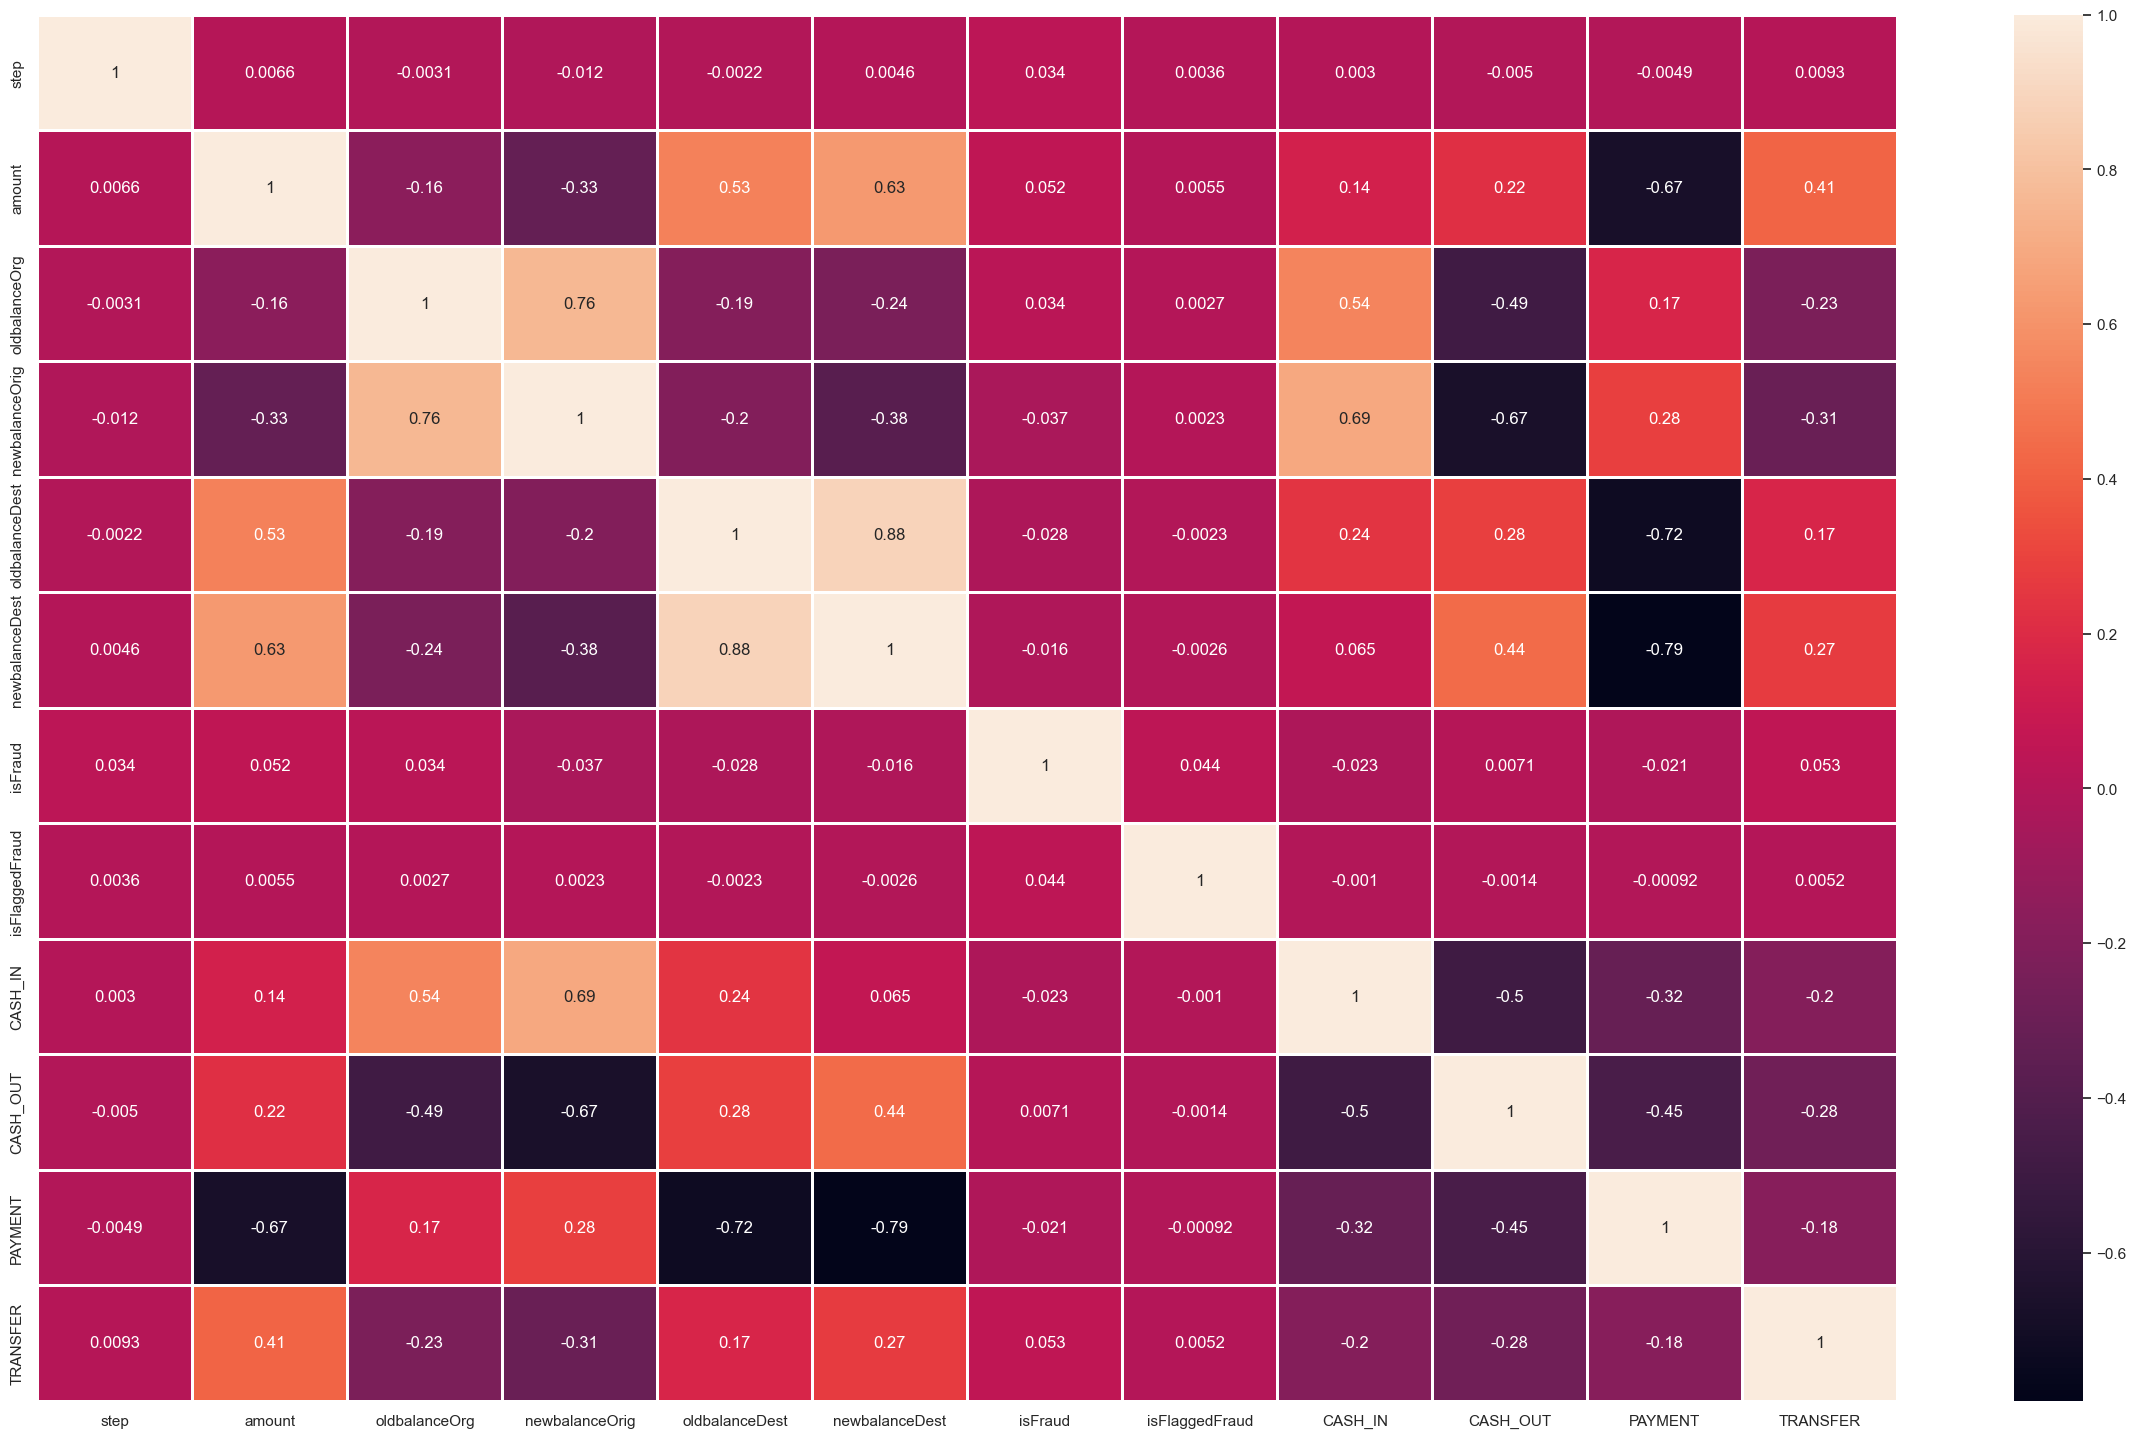

In [24]:
plt.figure(figsize = (30,18))
sns.heatmap(dff.corr(),annot=True,linewidths=0.75)

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=pd.DataFrame()
vif["VIF Factor"]=[variance_inflation_factor(dff.drop("isFraud",axis=1).values,i) for i in range(dff.drop("isFraud",axis=1).shape[1])]
vif["features"]=dff.drop("isFraud",axis=1).columns
print(vif)

    VIF Factor        features
0     3.856316            step
1     2.364608          amount
2     2.721778   oldbalanceOrg
3     6.036680  newbalanceOrig
4     6.174777  oldbalanceDest
5     8.773561  newbalanceDest
6     1.000217  isFlaggedFraud
7     3.607368         CASH_IN
8     3.641749        CASH_OUT
9     3.810851         PAYMENT
10    2.069163        TRANSFER


#### As Variation inflation factor for all columns is less than 10, there is no significant multicolinearity present in the datast.

#### As there is a significant difference between the fraudulent entries and non-fraudulent entries, we will use oversampling of data.

0    5348542
1    5348542
Name: isFraud, dtype: int64


<AxesSubplot:xlabel='isFraud', ylabel='count'>

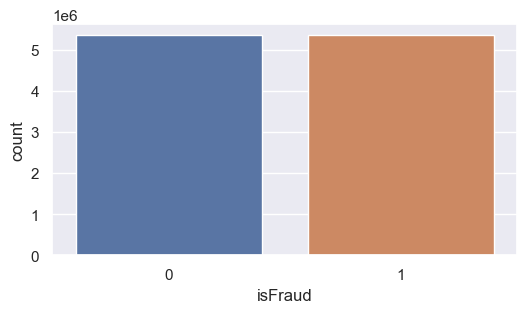

In [30]:
#Oversampling the data
dfy=dff["isFraud"]
dfx=dff.drop("isFraud", axis=1)
smt=SMOTE()
trainx, trainy=smt.fit_resample(dfx,dfy)
print(trainy.value_counts())
sns.countplot(trainy)

### Scaling of Independent features

In [31]:
y=dfy
st=StandardScaler()
xf=st.fit_transform(dfx)
x=pd.DataFrame(data=xf, columns=X.columns)

###  Preparing data for modelling

In [32]:
# Split 80-20 train vs test data
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.2,random_state=63)

In [33]:
print (train_x.shape, train_y.shape)
print (test_x.shape, test_y.shape)

(4285380, 11) (4285380,)
(1071345, 11) (1071345,)


### Training and testing of data

In [35]:
rfr_final=RandomForestClassifier(random_state=100, criterion="gini", min_samples_split=2)
rfr_final.fit(train_x,train_y)
prf=rfr_final.predict(test_x)
print(accuracy_score(test_y,prf))
score=cross_val_score(rfr_final,train_x,train_y,cv=5)
print("Cross Validation Score is :",score)
print("Mean Score :",score.mean())

0.9996546397285655
Cross Validation Score is : [0.99963014 0.99964297 0.99966747 0.9996103  0.99968031]
Mean Score : 0.9996462390733143


In [36]:
import joblib
joblib.dump(rfr_final,"fraud_detection_rfc.obj")

['fraud_detection_rfc.obj']

In [37]:
rfr_l=joblib.load('fraud_detection_rfc.obj')

In [38]:
result=rfr_l.predict(test_x)

In [39]:
print(accuracy_score(test_y,result))

0.9996546397285655


In [55]:
sklearn.metrics.roc_curve(test_y, result)

(array([0.00000000e+00, 2.43059483e-05, 1.00000000e+00]),
 array([0.        , 0.79126214, 1.        ]),
 array([2, 1, 0], dtype=int64))

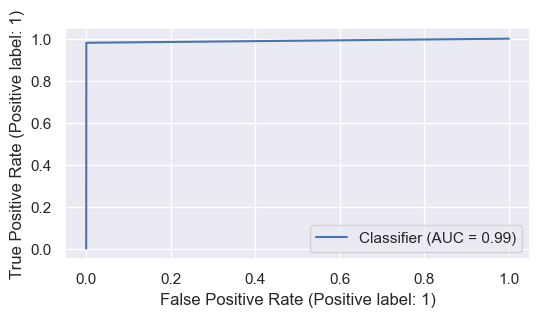

In [62]:
RocCurveDisplay.from_predictions(result,test_y)

This shows that the model has minimunm false predictions and is working near perfectly.

## What are the key factors that predict fraudulent customer?

In [40]:
rfr_l.feature_importances_

array([0.08722299, 0.14936944, 0.29064264, 0.02578148, 0.06010033,
       0.30586249, 0.00051768, 0.00413567, 0.02111606, 0.00448857,
       0.05076265])

In [42]:
rfr_l.feature_names_in_

array(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'CASH_IN',
       'CASH_OUT', 'PAYMENT', 'TRANSFER'], dtype=object)

In [54]:
dft=pd.DataFrame({"Feature Name":rfr_l.feature_names_in_, "Feature Importance(in%)":rfr_l.feature_importances_*100})
dft

,Feature Name,Feature Importance(in%)
0,step,8.722299
1,amount,14.936944
2,oldbalanceOrg,29.064264
3,newbalanceOrig,2.578148
4,oldbalanceDest,6.010033
5,newbalanceDest,30.586249
6,isFlaggedFraud,0.051768
7,CASH_IN,0.413567
8,CASH_OUT,2.111606
9,PAYMENT,0.448857


## What are the key factors that predict fraudulent customer? Do these factors make sense? If yes, How? If not, How not?

### According to the model, New balance at destination after the tranaction, old balance at origin before transaction and the amount of transaction are significant factors that predict fraudulent customer

    - This absolutely makes sense as more the balance in the account, more it is susceptible to being chosen for fraudulent transaction.
    - The greater the transacted amount, more chances are there for it to be a fraudulent transaction.
    - If amount and old balance at origin are equal then it shows that account has been emptied, and the trsnaction is fradulent.
    - However, new balance at the destination does not play such a significant role in determining whether the transaction is fraudulent.
    - It is also noticed that transferred transaction have contributed significantly for frauds as compared to other types of transaction.

## What kind of prevention should be adopted while company update its infrastructure?


### Following points should be kept in mind while updating its infrastructure to prevent it from fraud transaction.

    - The transaction should be cancelled if the transacted amount equals the old account balalnce at the origin.
    - The amount in Transfer transactions should be capped for each transaction.


## Assuming these actions have been implemented, how would you determine if they work?

    - Data monitoring: Monitor the input data to ensure that the data is consistent with the training data. The model may not work properly if the input data is significantly different from the training data.
    - Error analysis: Analyze the errors made by the model to identify patterns or issues that may need to be addressed.
    - Metrics evaluation: Evaluate the performance metrics of the model, such as accuracy, precision, recall, F1-score, and AUC, to ensure that the model is performing as expected.
